# Logistic Regression

The most common way to do Bayesian Logistic Regression is to use the Laplace Approximation.

## The Model

The model is the same as Linear Regression, except the output is passed through a Logistic Sigmoid to give output that is on [0,1].

$P(\mathbf{w}) = \mathcal{N}(\mathbf{0}, \alpha^{-1}\mathbf{I})$

$P(\mathbf{y} \mid \mathbf{X}, \mathbf{w} ) = \sigma(\mathcal{N}(\mathbf{Xw}, \beta^{-1}\mathbf{I}))$

## No More Conjugacy

This model is not conjugate - what we typically do is is approximate the posterior with a Normal distribution. This is a useful approximation, as we then have a conjugate posterior-likelihood pair. This means if we want a predictive distribution, everything is easy.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.datasets import make_classification
%matplotlib inline

In [26]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(LogisticRegression, self).__init__()
        self.approx_mean = torch.nn.Parameter(torch.ones(x_1s.shape[1]))
        self.approx_cov = torch.nn.Parameter(torch.from_numpy(np.arange(1,7)).float())
        self.bce = torch.nn.BCEWithLogitsLoss()
        self.sigmoid = torch.nn.Sigmoid()
        self.prior_mean = torch.from_numpy(np.zeros((in_features,))).float()
        self.prior_cov = torch.from_numpy(np.identity(in_features)).float()
        
    def forward(self, x, w):
        return torch.matmul(x,w)
    
    def forward_with_softmax(self, x,w):
        return self.sigmoid(self.forward(x,w))
    
    def loss(self, x, y, w):
        nll = torch.from_numpy(np.zeros(1)).float()
    
        y_hat = self.forward(x,w)
        return self.bce(y_hat, y)
     
    
    def NLL_prior(self, w):
        dw = w-self.prior_mean
        return torch.matmul(torch.matmul(dw, self.prior_cov), dw.transpose(0,1))
        

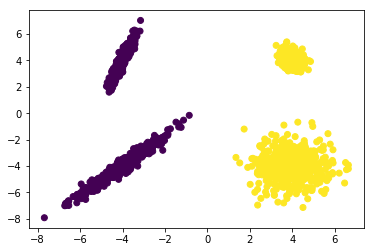

In [27]:
x, y = make_classification(n_samples=2000, flip_y=0, n_features=2, n_informative=2, n_redundant=0, class_sep=4.0)
plt.scatter(x[:,0], x[:,1], c=y)
x_1s = np.concatenate([np.ones((x.shape[0],1)), x], axis=1)

In [28]:
def vec_to_ldiag(vec, size):
    c = torch.zeros(size, size)
    c[torch.tril(torch.ones(size, size)) == 1] = vec
    c[torch.eye(size).byte()] = torch.nn.functional.sigmoid(c[torch.eye(size).byte()])
    return c

In [29]:
lr = LogisticRegression(x_1s.shape[1],1)


approx_chl = vec_to_ldiag(lr.approx_cov, x_1s.shape[1])

mvn = torch.distributions.MultivariateNormal(lr.approx_mean, scale_tril=approx_chl)

In [30]:
opt = torch.optim.Adam(lr.parameters(), lr=0.05)

In [32]:
x_t = torch.autograd.Variable(torch.from_numpy(x_1s).float())
y_t = torch.autograd.Variable(torch.from_numpy(y.reshape(-1,1)).float())
for t in range(5000):
    opt.zero_grad()
    ws = mvn.rsample(torch.Size([1]))
    loss = lr.loss(x_t,y_t, ws.transpose(0,1))
    loss.backward(retain_graph=True)
    opt.step()

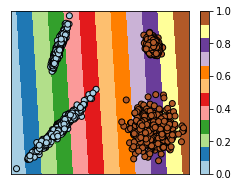

In [41]:
h=0.01
x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

xy_1s = np.c_[np.ones(len(xx.ravel())), xx.ravel(), yy.ravel()]

Z = lr.forward(torch.from_numpy(xy_1s).float(), lr.approx_mean).data.numpy()

# Put the result into a cololr plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.colorbar()
plt.show()

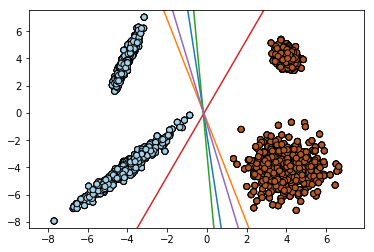

In [39]:
for i in range(5):
    w_sample =  mvn.sample()
    y_hat = lr.forward_with_softmax(x_t, w_sample)
    w_sample = w_sample.data.numpy()
    x1 = np.arange(x_min, x_max, h)
    x2  =(-w_sample[0] - x1*w_sample[1])/w_sample[2]
    plt.plot(x1,x2)
    plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.ylim([y_min,y_max])

In [42]:
mvn.covariance_matrix


  0.5344   1.4621   2.9242
  1.4621   4.9074  12.7629
  2.9242  12.7629  41.9951
[torch.FloatTensor of size (3,3)]